In [ ]:
#MIT License

#Copyright (c) [2021] [Oliver Böhme]

#Permission is hereby granted, free of charge, to any person obtaining a copy
#of this software and associated documentation files (the "Software"), to deal
#in the Software without restriction, including without limitation the rights
#to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
#copies of the Software, and to permit persons to whom the Software is
#furnished to do so, subject to the following conditions:

#The above copyright notice and this permission notice shall be included in all
#copies or substantial portions of the Software.

#THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
#IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
#FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
#AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
#LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
#OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
#SOFTWARE.

In [1]:
#Problem Framing:

#There are many ways to harness and explore a given dataset.
#In this paper, we will use the data to explore a very specific question; that is:
#Given recent number of problems and influencal factors what is the expected number of problems for the upcoming time steps until we reach SOP?

#This requires that a predictive model forecasts the total number of errors for each week over the residual weeks.

#Technically, this framing of the problem is referred to as a multivariate multi-step time series forecasting problem, given the multiple forecast steps. 
#A model, that makes use of multiple input variables may be referred to as a multivariate multi-step time series forecasting model.
#A model of this type could be helpful within the <Anwendungsfall>
#It could also be helpful on the <Anwendungsfall>.

#Data Description
#Non-stationarity is when the statistical properties of a series, e.g the mean, variance, and covariance (or the process generating the series) changes over time. 
#Non-stationary series are typically difficult to model and forecast and are therefore required to be made stationary to obtain meaningful results as many statistical tools and processes require stationarity. 
#A proven method of stationarizing a non-stationary series is through the use of differencing.

#Credits
#https://machinelearningmastery.com/how-to-develop-lstm-models-for-multi-step-time-series-forecasting-of-household-power-consumption/

In [2]:
#Import Libraries:

import pandas as pd
from pandas import read_csv
from pandas import to_numeric

import numpy as np
from numpy import split
from numpy import array
from numpy import nan
from numpy import isnan

import csv
import math
from math import sqrt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Conv1D, LSTM, Dense, GRU, Flatten, RepeatVector, TimeDistributed

import matplotlib.pyplot as plt
from matplotlib import pyplot

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler


Shape of the Dataset_raw:  (49920, 11)


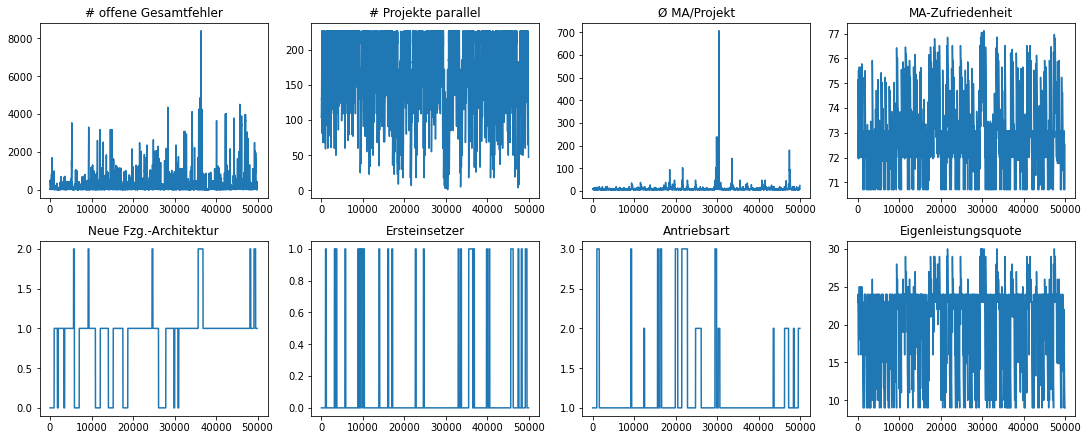

In [3]:
#Import DataSet:

data_raw = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/DataSet_Prediction_multivariat_preprocessed_feature selected_v04e_20211003_OB.xlsm',0)
print('Shape of the Dataset_raw: ',data_raw.shape)
data_raw.head()

#Drop unneccessary Columns:
dataset = data_raw.iloc[:,3:11]

#Plot the Data
figure, axis = plt.subplots(2,4, figsize=(15,6), constrained_layout=True)

axis[0,0].plot(dataset.iloc[:,0:1])
axis[0,0].set_title("# offene Gesamtfehler")

axis[0,1].plot(dataset.iloc[:,1:2])
axis[0,1].set_title("# Projekte parallel")

axis[0,2].plot(dataset.iloc[:,2:3])
axis[0,2].set_title("Ø MA/Projekt")

axis[0,3].plot(dataset.iloc[:,3:4])
axis[0,3].set_title("MA-Zufriedenheit")

axis[1,0].plot(dataset.iloc[:,4:5])
axis[1,0].set_title("Neue Fzg.-Architektur")

axis[1,1].plot(dataset.iloc[:,5:6])
axis[1,1].set_title("Ersteinsetzer")

axis[1,2].plot(dataset.iloc[:,6:7])
axis[1,2].set_title("Antriebsart")

axis[1,3].plot(dataset.iloc[:,7:8])
axis[1,3].set_title("Eigenleistungsquote")

plt.show()

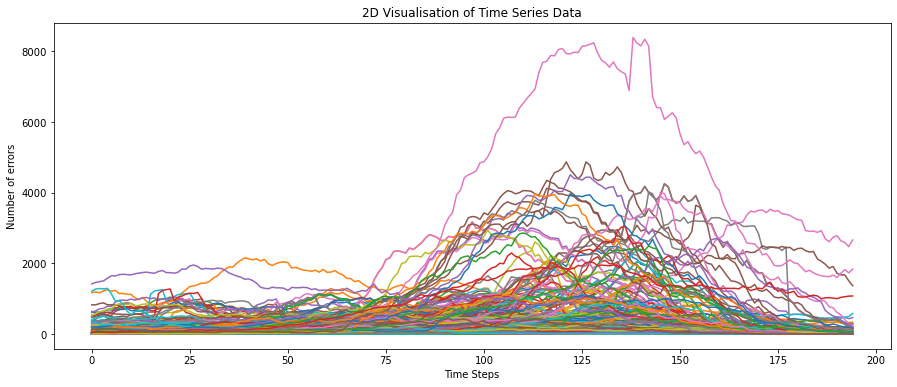

In [4]:
#Plot offene Gesamtfehler
projects2visualize = dataset
time = np.arange(len(projects2visualize))

plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Number of errors")
plt.title("2D Visualisation of Time Series Data")
    
for i in range(0,256):
    plt.plot(time[0:195], projects2visualize.iloc[i*195:((i*195)+195),0:1])

plt.show()


In [23]:
#Choose Feature Set:
dataset = data_raw.iloc[:,3:5]
print('Shape of the Dataset: ',dataset.shape)
print(dataset.head())


Shape of the Dataset:  (49920, 2)
   Anzahl offene Gesamtfehler  Anzahl parallel entwickelter Projekte
0                          21                                    104
1                          16                                    104
2                          12                                    104
3                          12                                    106
4                          12                                    109


In [24]:
#Define Length of Input/Output Sequences:

n_input = 135
n_out = 60


In [25]:
#Split multivariate DataSet into Train/ Test Sets:

#Normalize Dataset
#scaler = MinMaxScaler()
#dataset_scaled = scaler.fit_transform(dataset)


#Split into Length of Car Projects (195 time stamps)
split_time = math.ceil(0.5*len(dataset)/195)*195 #Ratio: 70/30 #Define Ratio Train/Test-Split
train, test = dataset[:split_time], dataset[split_time:]
#train, test = dataset_scaled[:split_time], dataset_scaled[split_time:] #Normalize Data
    
#Restructure into Windows of Length of one Verhicle Project
train = array(split(train, len(train)/195))
test = array(split(test, len(test)/195))


#Testing/Bugfixing
print("Train Shape: ", train.shape)
print("Test Shape: ", test.shape)


Train Shape:  (128, 195, 2)
Test Shape:  (128, 195, 2)


In [26]:
#Data Preparation: Convert Train-DataSet into Inputs and Outputs:

#Flatten Data
data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))

X, y = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_input = data[in_start:in_end, 0]
        X_input = X_input.reshape((len(X_input), 1))
        X.append(data[in_start:in_end, :])
        y.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

#Debug
print(array(X).shape)
print(array(y).shape)
#print(array(X)[0:330])
#print(array(y)[0:330])

(128, 135, 2)
(128, 60)


In [27]:
#Data Preparation: Convert Test-DataSet into Inputs and Outputs:

#Flatten Data
data = test.reshape((test.shape[0]*test.shape[1], test.shape[2]))

X_test, y_test = list(), list()
in_start = 0
    
#Step over the entire History one time step at a time
for i in range(len(data)):
    #Define the End of the Input/Output Sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
        
    #Ensure to have enough Data for this Instance
    if out_end <= len(data):
        X_test_input = data[in_start:in_end, 0]
        X_test_input = X_test_input.reshape((len(X_test_input), 1))
        X_test.append(data[in_start:in_end, :])
        y_test.append(data[in_end:out_end, 0])
        
    #Move along one time step
    in_start += 195

X_test = array(X_test)
y_test = array(y_test)
#Debug
#print(array(X_test).shape)
#print(array(y_test).shape)
#print(array(X_test)[0:330])
#print(array(y_test)[0:330])

In [28]:
#Define and train the Model:

#Prepare Data
train_x, train_y = array(X), array(y)

#Define Parameters
verbose, epochs, batch_size = 1, 2000, 16
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
#print("n_timesteps, n_features, n_outputs: ",n_timesteps, n_features, n_outputs)

#Reshape Output into [samples, timesteps, features]
train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1)) 
    
#Define Transformer Encoder
#Credits: https://keras.io/examples/timeseries/timeseries_transformer_classification/
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    #Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    #Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

#Define Build Model Function
#Credits: https://keras.io/examples/timeseries/timeseries_transformer_classification/
def build_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = keras.Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)
        
    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)
    outputs = layers.Dense(units=n_out, activation="relu")(x)

    return keras.Model(inputs, outputs)

#Define Model
model = build_model(input_shape=(n_timesteps, n_features), head_size=256, num_heads=1, ff_dim=4, num_transformer_blocks=4, mlp_units=[128], mlp_dropout=0.4, dropout=0.25)

model.compile(loss='mae', optimizer='adam')

#Fit the Model
model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)

Epoch 1/2000
8/8 [==============================] - 2s 81ms/step - loss: 188.7815
Epoch 2/2000
8/8 [==============================] - 1s 80ms/step - loss: 167.7432
Epoch 3/2000
8/8 [==============================] - 1s 80ms/step - loss: 158.6808
Epoch 4/2000
8/8 [==============================] - 1s 81ms/step - loss: 153.8950
Epoch 5/2000
8/8 [==============================] - 1s 80ms/step - loss: 148.2076
Epoch 6/2000
8/8 [==============================] - 1s 79ms/step - loss: 143.3376
Epoch 7/2000
8/8 [==============================] - 1s 80ms/step - loss: 137.7886
Epoch 8/2000
8/8 [==============================] - 1s 80ms/step - loss: 132.7043
Epoch 9/2000
8/8 [==============================] - 1s 79ms/step - loss: 130.6895
Epoch 10/2000
8/8 [==============================] - 1s 81ms/step - loss: 126.8614
Epoch 11/2000
8/8 [==============================] - 1s 79ms/step - loss: 125.9464
Epoch 12/2000
8/8 [==============================] - 1s 78ms/step - loss: 123.5950
Epoch 13/2000

8/8 [==============================] - 1s 123ms/step - loss: 90.6364
Epoch 199/2000
8/8 [==============================] - 1s 121ms/step - loss: 84.7178
Epoch 200/2000
8/8 [==============================] - 1s 125ms/step - loss: 83.2921
Epoch 201/2000
8/8 [==============================] - 1s 121ms/step - loss: 82.3691
Epoch 202/2000
8/8 [==============================] - 1s 119ms/step - loss: 89.8308
Epoch 203/2000
8/8 [==============================] - 1s 119ms/step - loss: 80.5605
Epoch 204/2000
8/8 [==============================] - 1s 125ms/step - loss: 88.7236
Epoch 205/2000
8/8 [==============================] - 1s 121ms/step - loss: 82.8172
Epoch 206/2000
8/8 [==============================] - 1s 122ms/step - loss: 87.3373
Epoch 207/2000
8/8 [==============================] - 1s 119ms/step - loss: 87.4857
Epoch 208/2000
8/8 [==============================] - 1s 119ms/step - loss: 85.7166
Epoch 209/2000
8/8 [==============================] - 1s 119ms/step - loss: 87.6384
Epoch 2

8/8 [==============================] - 1s 121ms/step - loss: 78.0402
Epoch 393/2000
8/8 [==============================] - 1s 120ms/step - loss: 78.9924
Epoch 394/2000
8/8 [==============================] - 1s 118ms/step - loss: 79.5686
Epoch 395/2000
8/8 [==============================] - 1s 117ms/step - loss: 80.9948
Epoch 396/2000
8/8 [==============================] - 1s 123ms/step - loss: 77.8339
Epoch 397/2000
8/8 [==============================] - 1s 118ms/step - loss: 80.0158
Epoch 398/2000
8/8 [==============================] - 1s 124ms/step - loss: 82.2529
Epoch 399/2000
8/8 [==============================] - 1s 120ms/step - loss: 81.2709
Epoch 400/2000
8/8 [==============================] - 1s 120ms/step - loss: 79.2899
Epoch 401/2000
8/8 [==============================] - 1s 122ms/step - loss: 86.8807
Epoch 402/2000
8/8 [==============================] - 1s 122ms/step - loss: 83.3684
Epoch 403/2000
8/8 [==============================] - 1s 122ms/step - loss: 82.4103
Epoch 4

8/8 [==============================] - 1s 121ms/step - loss: 81.8652
Epoch 587/2000
8/8 [==============================] - 1s 123ms/step - loss: 79.1136
Epoch 588/2000
8/8 [==============================] - 1s 123ms/step - loss: 76.8245
Epoch 589/2000
8/8 [==============================] - 1s 122ms/step - loss: 76.8916
Epoch 590/2000
8/8 [==============================] - 1s 120ms/step - loss: 75.2359
Epoch 591/2000
8/8 [==============================] - 1s 121ms/step - loss: 75.9261
Epoch 592/2000
8/8 [==============================] - 1s 115ms/step - loss: 80.7427
Epoch 593/2000
8/8 [==============================] - 1s 123ms/step - loss: 73.8005
Epoch 594/2000
8/8 [==============================] - 1s 122ms/step - loss: 82.5542
Epoch 595/2000
8/8 [==============================] - 1s 120ms/step - loss: 76.8664
Epoch 596/2000
8/8 [==============================] - 1s 120ms/step - loss: 73.7392
Epoch 597/2000
8/8 [==============================] - 1s 119ms/step - loss: 84.2689
Epoch 5

8/8 [==============================] - 1s 125ms/step - loss: 76.5593
Epoch 781/2000
8/8 [==============================] - 1s 122ms/step - loss: 73.1696
Epoch 782/2000
8/8 [==============================] - 1s 123ms/step - loss: 79.8985
Epoch 783/2000
8/8 [==============================] - 1s 125ms/step - loss: 78.9720
Epoch 784/2000
8/8 [==============================] - 1s 123ms/step - loss: 74.3928
Epoch 785/2000
8/8 [==============================] - 1s 122ms/step - loss: 74.1214
Epoch 786/2000
8/8 [==============================] - 1s 121ms/step - loss: 68.7590
Epoch 787/2000
8/8 [==============================] - 1s 123ms/step - loss: 73.7341
Epoch 788/2000
8/8 [==============================] - 1s 122ms/step - loss: 72.3380
Epoch 789/2000
8/8 [==============================] - 1s 121ms/step - loss: 71.7714
Epoch 790/2000
8/8 [==============================] - 1s 130ms/step - loss: 79.4243
Epoch 791/2000
8/8 [==============================] - 1s 122ms/step - loss: 74.4473
Epoch 7

8/8 [==============================] - 1s 126ms/step - loss: 72.5888
Epoch 975/2000
8/8 [==============================] - 1s 126ms/step - loss: 77.7906
Epoch 976/2000
8/8 [==============================] - 1s 122ms/step - loss: 80.6167
Epoch 977/2000
8/8 [==============================] - 1s 121ms/step - loss: 78.9516
Epoch 978/2000
8/8 [==============================] - 1s 124ms/step - loss: 79.0605
Epoch 979/2000
8/8 [==============================] - 1s 125ms/step - loss: 75.2802
Epoch 980/2000
8/8 [==============================] - 1s 122ms/step - loss: 71.5328
Epoch 981/2000
8/8 [==============================] - 1s 125ms/step - loss: 72.2121
Epoch 982/2000
8/8 [==============================] - 1s 124ms/step - loss: 72.8564
Epoch 983/2000
8/8 [==============================] - 1s 129ms/step - loss: 78.5146
Epoch 984/2000
8/8 [==============================] - 1s 123ms/step - loss: 70.3344
Epoch 985/2000
8/8 [==============================] - 1s 123ms/step - loss: 75.8348
Epoch 9

8/8 [==============================] - 1s 120ms/step - loss: 77.8963
Epoch 1167/2000
8/8 [==============================] - 1s 120ms/step - loss: 75.4053
Epoch 1168/2000
8/8 [==============================] - 1s 120ms/step - loss: 72.8530
Epoch 1169/2000
8/8 [==============================] - 1s 122ms/step - loss: 73.2381
Epoch 1170/2000
8/8 [==============================] - 1s 120ms/step - loss: 73.2804
Epoch 1171/2000
8/8 [==============================] - 1s 120ms/step - loss: 78.9683
Epoch 1172/2000
8/8 [==============================] - 1s 121ms/step - loss: 75.8379
Epoch 1173/2000
8/8 [==============================] - 1s 123ms/step - loss: 69.4606
Epoch 1174/2000
8/8 [==============================] - 1s 119ms/step - loss: 74.1987
Epoch 1175/2000
8/8 [==============================] - 1s 124ms/step - loss: 69.1123
Epoch 1176/2000
8/8 [==============================] - 1s 120ms/step - loss: 76.5130
Epoch 1177/2000
8/8 [==============================] - 1s 119ms/step - loss: 77.3

8/8 [==============================] - 1s 123ms/step - loss: 69.4746
Epoch 1359/2000
8/8 [==============================] - 1s 118ms/step - loss: 72.2693
Epoch 1360/2000
8/8 [==============================] - 1s 124ms/step - loss: 68.6684
Epoch 1361/2000
8/8 [==============================] - 1s 123ms/step - loss: 76.5271
Epoch 1362/2000
8/8 [==============================] - 1s 123ms/step - loss: 70.8476
Epoch 1363/2000
8/8 [==============================] - 1s 120ms/step - loss: 73.5362
Epoch 1364/2000
8/8 [==============================] - 1s 121ms/step - loss: 74.7459
Epoch 1365/2000
8/8 [==============================] - 1s 126ms/step - loss: 73.3998
Epoch 1366/2000
8/8 [==============================] - 1s 124ms/step - loss: 74.1134
Epoch 1367/2000
8/8 [==============================] - 1s 124ms/step - loss: 75.8872
Epoch 1368/2000
8/8 [==============================] - 1s 121ms/step - loss: 70.1776
Epoch 1369/2000
8/8 [==============================] - 1s 121ms/step - loss: 76.3

8/8 [==============================] - 1s 121ms/step - loss: 74.5813
Epoch 1551/2000
8/8 [==============================] - 1s 123ms/step - loss: 71.6673
Epoch 1552/2000
8/8 [==============================] - 1s 118ms/step - loss: 69.2285
Epoch 1553/2000
8/8 [==============================] - 1s 118ms/step - loss: 77.8207
Epoch 1554/2000
8/8 [==============================] - 1s 120ms/step - loss: 75.4955
Epoch 1555/2000
8/8 [==============================] - 1s 119ms/step - loss: 72.4441
Epoch 1556/2000
8/8 [==============================] - 1s 123ms/step - loss: 67.9595
Epoch 1557/2000
8/8 [==============================] - 1s 122ms/step - loss: 74.2110
Epoch 1558/2000
8/8 [==============================] - 1s 118ms/step - loss: 67.7989
Epoch 1559/2000
8/8 [==============================] - 1s 120ms/step - loss: 77.8758
Epoch 1560/2000
8/8 [==============================] - 1s 120ms/step - loss: 74.5456
Epoch 1561/2000
8/8 [==============================] - 1s 119ms/step - loss: 73.7

8/8 [==============================] - 1s 120ms/step - loss: 74.2080
Epoch 1743/2000
8/8 [==============================] - 1s 125ms/step - loss: 74.0123
Epoch 1744/2000
8/8 [==============================] - 1s 125ms/step - loss: 72.4689
Epoch 1745/2000
8/8 [==============================] - 1s 120ms/step - loss: 71.8730
Epoch 1746/2000
8/8 [==============================] - 1s 121ms/step - loss: 75.8963
Epoch 1747/2000
8/8 [==============================] - 1s 119ms/step - loss: 75.3464
Epoch 1748/2000
8/8 [==============================] - 1s 123ms/step - loss: 73.5286
Epoch 1749/2000
8/8 [==============================] - 1s 122ms/step - loss: 75.0101
Epoch 1750/2000
8/8 [==============================] - 1s 124ms/step - loss: 70.2858
Epoch 1751/2000
8/8 [==============================] - 1s 124ms/step - loss: 72.2623
Epoch 1752/2000
8/8 [==============================] - 1s 124ms/step - loss: 74.8658
Epoch 1753/2000
8/8 [==============================] - 1s 124ms/step - loss: 69.2

8/8 [==============================] - 1s 123ms/step - loss: 72.3019
Epoch 1935/2000
8/8 [==============================] - 1s 123ms/step - loss: 74.0893
Epoch 1936/2000
8/8 [==============================] - 1s 124ms/step - loss: 75.0564
Epoch 1937/2000
8/8 [==============================] - 1s 123ms/step - loss: 72.6657
Epoch 1938/2000
8/8 [==============================] - 1s 118ms/step - loss: 72.5645
Epoch 1939/2000
8/8 [==============================] - 1s 128ms/step - loss: 76.7419
Epoch 1940/2000
8/8 [==============================] - 1s 122ms/step - loss: 78.3099
Epoch 1941/2000
8/8 [==============================] - 1s 120ms/step - loss: 73.1827
Epoch 1942/2000
8/8 [==============================] - 1s 121ms/step - loss: 70.1959
Epoch 1943/2000
8/8 [==============================] - 1s 119ms/step - loss: 79.7704
Epoch 1944/2000
8/8 [==============================] - 1s 122ms/step - loss: 72.5927
Epoch 1945/2000
8/8 [==============================] - 1s 124ms/step - loss: 70.4

Predict the last 60 Values of the last Vehicle Development Project:



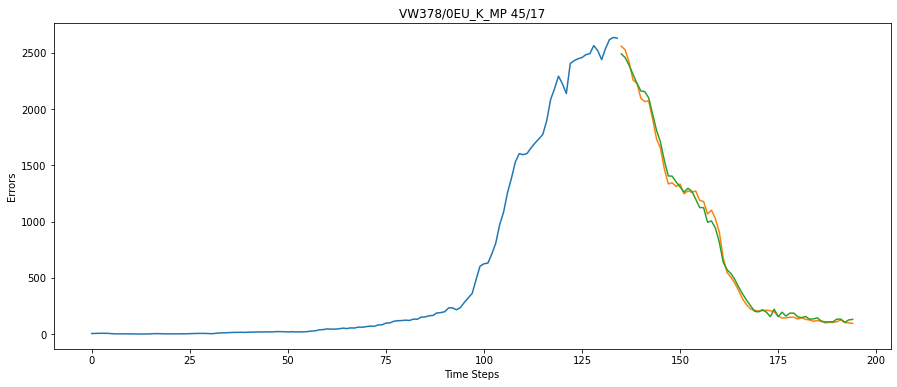

In [29]:
#Make Forecasts:
print("Predict the last 60 Values of the last Vehicle Development Project:\n")
#Flatten Data
history = [x for x in train] #Note: History = train
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
y = train_y.reshape((train_y.shape[0]*train_y.shape[1], train_y.shape[2]))[-n_out:]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("VW378/0EU_K_MP 45/17")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], y[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Multi-Head Attention Network: [351.818] 104.8, 99.7, 108.2, 134.0, 143.7, 153.5, 166.7, 182.5, 168.5, 174.3, 192.1, 200.2, 203.9, 198.8, 205.6, 207.6, 206.9, 206.4, 206.1, 212.8, 208.1, 211.1, 203.6, 207.5, 197.3, 194.0, 192.3, 197.0, 194.2, 195.0, 186.6, 182.8, 182.0, 175.6, 175.8, 172.1, 169.9, 167.0, 163.9, 150.7, 147.5, 146.9, 139.3, 138.0, 135.2, 127.3, 123.7, 118.3, 112.0, 106.5, 100.9, 95.7, 91.5, 89.1, 87.6, 84.2, 82.1, 78.5, 74.2, 74.9


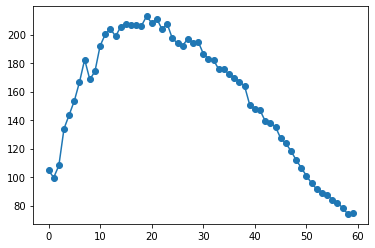

Overall MAE:  351.81780328353324


In [30]:
#Evaluate the Model:

predictions = list()

#print("Test Shape: ",test.shape)
for i in range(test.shape[0]):
    #Predict the Output Sequence
    history = test[i:i+1,:,:] #for each Car Project
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        
    #Retrieve last Observations for Input Data
    input_x = data[-n_input-n_out:-n_out, :]
    
    #Reshape into [1, n_input, n]
    input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
    
    #Forecast
    yhat = model.predict(input_x, verbose=0)
    
    #We only want the Vector Forecast
    yhat_sequence = yhat[0]
        
    #Store the Predictions
    predictions.append(yhat_sequence)
        
#print("Predictions Shape: ",array(predictions).shape)

#Evaluate predicted Time Steps for each Car Project
predictions = array(predictions)
scores = list()
actual, predicted = array(y_test), array(predictions)

#print(array(actual).shape)
#print(array(predicted).shape)

for i in range(predicted.shape[1]):
    #Calculate MSE
    #mse = mean_squared_error(actual[:, i], predicted[:, i])
    
    #Calculate RMSE
    #rmse = sqrt(mse)
    
    #Calculate MAE
    mae = mean_absolute_error(actual[:, i], predicted[:, i])
    #print("Step: ",i)
    #print("y", actual[:,i])
    #print("yhat", predicted[:,i])
    #print("MAE: ", mae)
    
    #Store the Scores
    #scores.append(rmse)
    scores.append(mae)

#Calculate overall MAE (alternative: RMSE)
s = 0
    
for row in range(predicted.shape[0]):
    for col in range(predicted.shape[1]):
        s += (actual[row, col] - predicted[row, col])**2
    
score = sqrt(s / (actual.shape[0] * actual.shape[1]))

#Visualize MAE
s_scores = ', '.join(['%.1f' % s for s in scores])
print('%s: [%.3f] %s' % ('Multi-Head Attention Network', score, s_scores))

pyplot.plot(scores, marker='o', label='lstm')
pyplot.show()


print("Overall MAE: ",score)

In [31]:
###########################################################################################################################
########################################## Visualization of Predicted Data ################################################
###########################################################################################################################

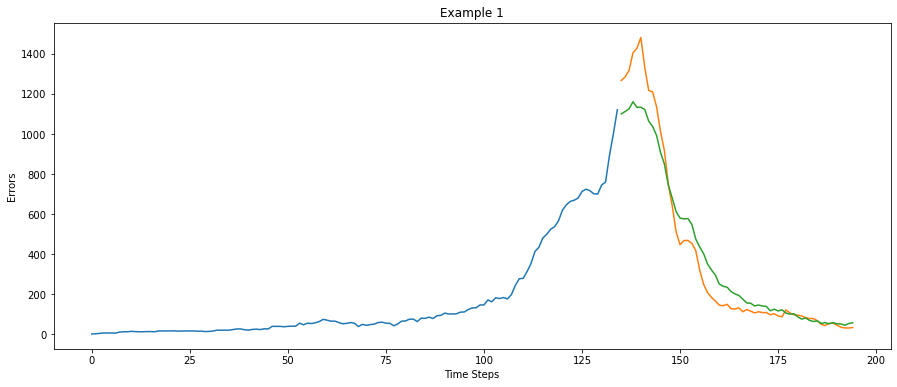

In [32]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 1
example=1
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 1")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

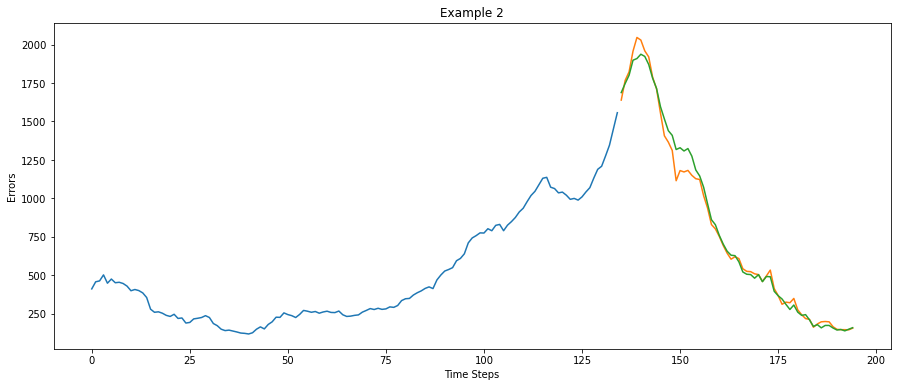

In [33]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 2
example=2
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 2")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

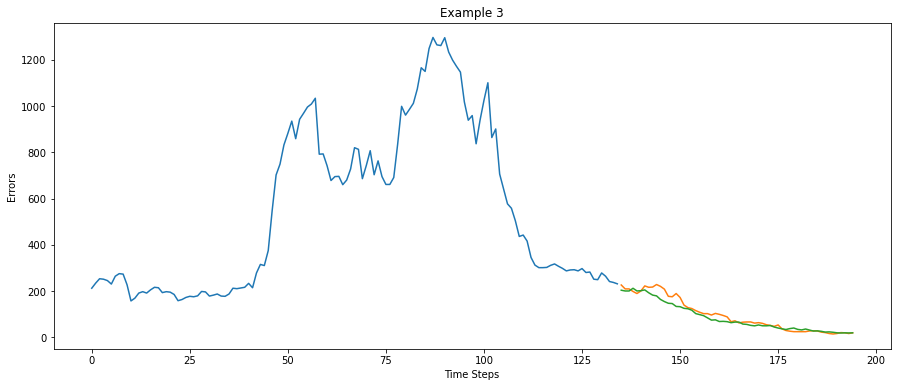

In [34]:
#Show Predictions Test-Set/Predictive-Set
#Define Data Range - Example 3
example=30
X_test_data=X_test.reshape((X_test.shape[0]*X_test.shape[1], X_test.shape[2]))
X_test_data=X_test_data[:,0:1]
y_test_data=y_test.reshape(y_test.shape[0]*y_test.shape[1])
#print(X_test_data.shape)
prediction_data=predicted.reshape((predicted.shape[0]*predicted.shape[1]))
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Example 3")

plt.plot(time[0:135], X_test_data[(example-1)*n_input:example*n_input])
plt.plot(time[135:195], y_test_data[(example-1)*n_out:example*n_out])
plt.plot(time[135:195], prediction_data[(example-1)*n_out:example*n_out])

plt.show()

In [35]:
###########################################################################################################################
########################################## Verifikation am realen Beispiel ################################################
###########################################################################################################################

Predict the last 60 Values of the test vehicle project:



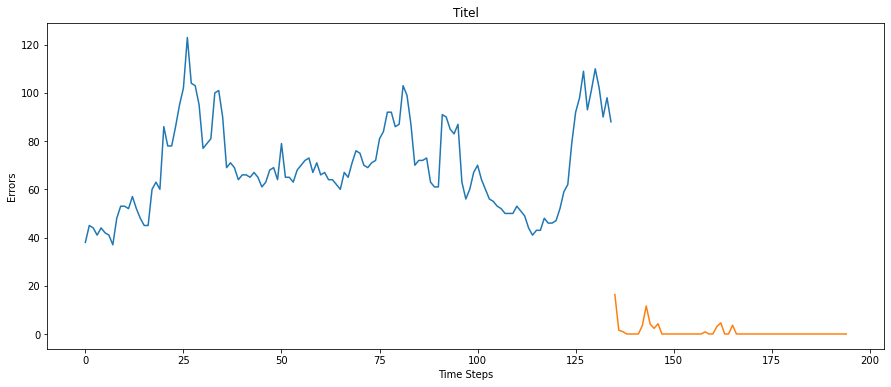

In [36]:
#Import Validation Data
validation_data = pd.read_excel('S:/03_Promotion/03_Veröffentlichungen/02_Paper/04_Prediction/Experiment/X_Test_Prediction_multivariat_preprocessed_v03e_20211003_OB.xlsm',0)
#print('Shape des RAW-Datasets: ',validation_data.shape)
validation_data.head()

#Drop unneccessary Columns:
validation_data = validation_data.iloc[:,3:5]
#print('Shape of the Dataset: ',validation_data.shape)
#print(validation_data.head())

#Normalize Input Data
#scaler = MinMaxScaler()
#validation_data_scaled = scaler.fit_transform(validation_data)

#Set nth sample to show
n=1

#Manuelle Definition Array erstes reales Verifikationsbeispiel x1 
#x1 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x1 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x1 = array(split(x1, len(x1)/195))
#print("Shape x1: \n",x1.shape,"\n")
#print("x1: \n",x1)

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x1 #Note: History = x1
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()

Predict the last 60 Values of the test vehicle project:



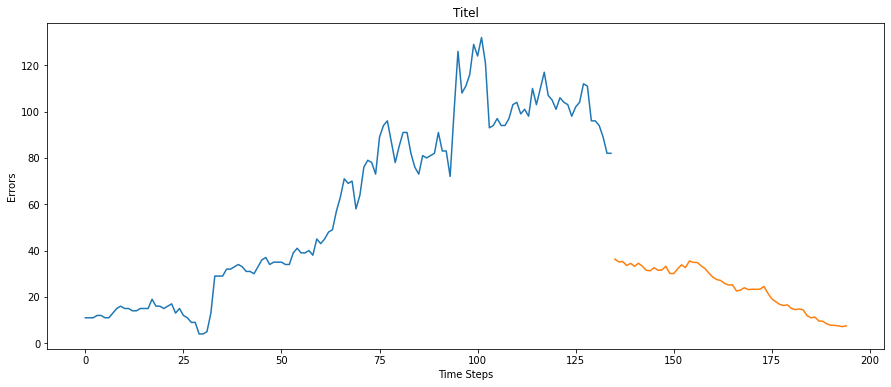

In [37]:
#Set nth sample
n=2

#Manuelle Definition Array erstes reales Verifikationsbeispiel x2
#x2 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x2 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x2 = array(split(x2, len(x2)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x2
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



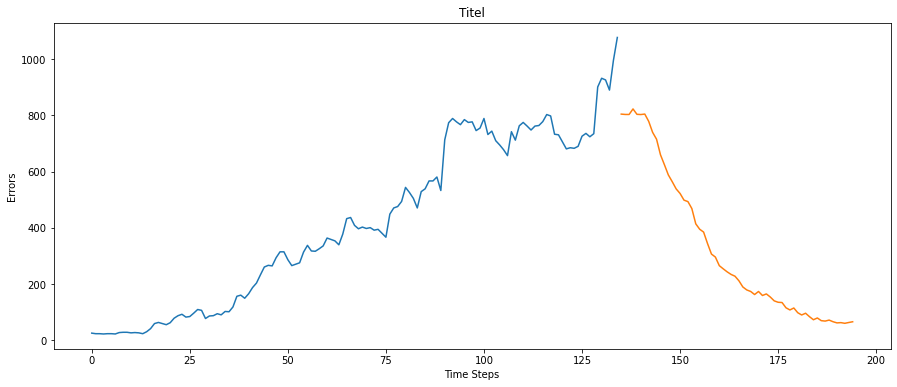

In [38]:
#Set nth sample
n=3

#Manuelle Definition Array erstes reales Verifikationsbeispiel x3 
#x3 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x3 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x3 = array(split(x3, len(x3)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x3
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



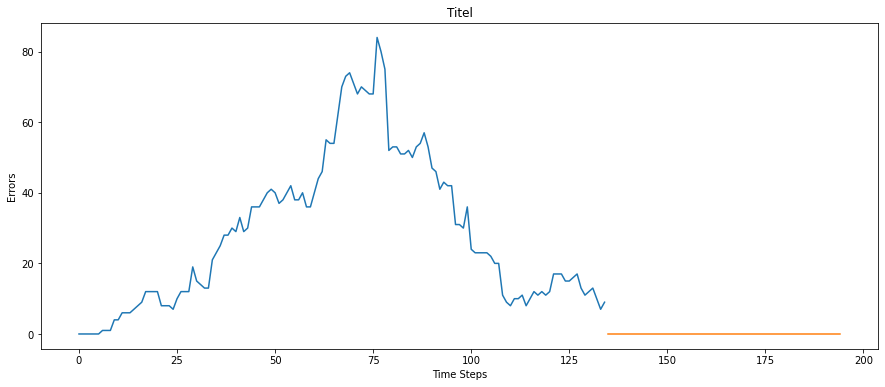

In [39]:
#Set nth sample
n=4

#Manuelle Definition Array erstes reales Verifikationsbeispiel x4
#x4 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x4 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x4 = array(split(x4, len(x4)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x4
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()


Predict the last 60 Values of the test vehicle project:



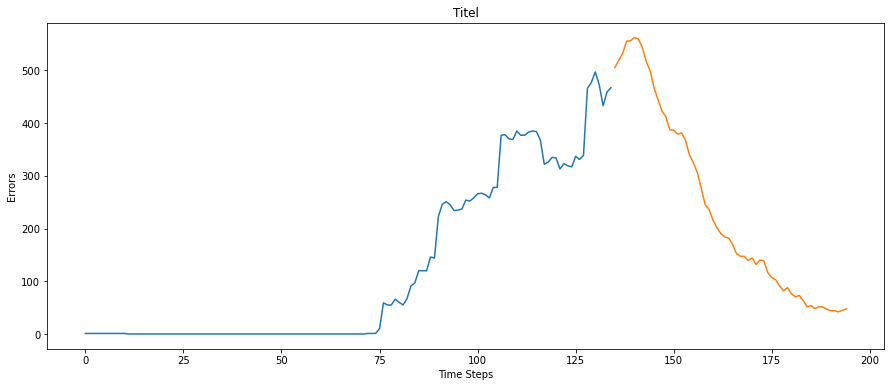

In [40]:
#Set nth sample
n=7

#Manuelle Definition Array erstes reales Verifikationsbeispiel x5
#x4 = np.array(validation_data_scaled[(n-1)*195:n*195,:]) #normalized
x5 = np.array(validation_data.iloc[(n-1)*195:n*195,:])
x5 = array(split(x5, len(x5)/195))

#Make Forecasts:
print("Predict the last 60 Values of the test vehicle project:\n")
#Flatten Data
history = x5
data = array(history)
data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
#print("Shape History: ",data.shape)

#Retrieve last Observations for Input Data
input_x = data[-n_input-n_out:-n_out, :]
#print(input_x.shape)

#Reshape into [1, n_input, n]
input_x = input_x.reshape((1, input_x.shape[0], input_x.shape[1])) #multivariate
#print("Shape input_x: ",input_x.shape)

#Forecast
yhat = model.predict(input_x, verbose=0)
    
#We only want the Vector Forecast
yhat = yhat[0]
#print("Length yhat: ",len(yhat),"\n")
#print("Array yhat: ",yhat)


#Vergleich y_train mit yhat im letzten Trainingsbeispiel
X = input_x.reshape((input_x.shape[0]*input_x.shape[1], input_x.shape[2]))[:,0]
yhat = yhat
time = np.arange(len(dataset))

#Plot Data
plt.figure(figsize=(15, 6))
plt.xlabel("Time Steps")
plt.ylabel("Errors")
plt.title("Titel")

plt.plot(time[0:135], X[:])
plt.plot(time[135:195], yhat[:])

plt.show()
